In [57]:
import pickle
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import os
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy import interp
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder as LE
import time
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
import random
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
def classification_report_csv(report, csv_file_name):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(csv_file_name, index = False)

In [3]:
def get_embedding_dicts(tr_embeddings = 'CCNA_full_training_embeddings_facenet_model_v1.npy', ts_embeddings = 'CCNA_full_testing_embeddings_facenet_model_v1.npy', tr_image_names = 'ccna_full_training_image_names_list.npy', ts_image_names='ccna_full_testing_image_names_list.npy'):
    training_embeddings = np.load(tr_embeddings)
    training_image_names = np.load(tr_image_names)
    training_labels = np.asarray([image_name.split('/')[-2] for image_name in training_image_names])
    training_sku_id_set = list(set(training_labels))

    testing_embeddings = np.load(ts_embeddings)
    testing_image_names = np.load(ts_image_names)
    testing_labels = np.asarray([image_name.split('/')[-2] for image_name in testing_image_names])
    testing_sku_id_set = list(set(testing_labels))
    
    total_sku_set = list(set(training_sku_id_set+testing_sku_id_set))
    
    print ('\nFound a total of '+str(len(total_sku_set))+' SKUs in both testing and training.\n')
    
    training_embedding_dict = {}
    testing_embedding_dict = {}
    
    for i in range(len(training_embeddings)):
        if training_labels[i] not in training_embedding_dict.keys():
            training_embedding_dict[training_labels[i]] = np.asarray([training_embeddings[i]])
        else:
            training_embedding_dict[training_labels[i]] = np.vstack((training_embedding_dict[training_labels[i]], np.asarray([training_embeddings[i]])))
    
    for i in range(len(testing_embeddings)):
        if testing_labels[i] not in testing_embedding_dict.keys():
            testing_embedding_dict[testing_labels[i]] = np.asarray([testing_embeddings[i]])
        else:
            testing_embedding_dict[testing_labels[i]] = np.vstack((testing_embedding_dict[testing_labels[i]], np.asarray([testing_embeddings[i]])))
    
    return total_sku_set, training_embedding_dict, testing_embedding_dict

In [4]:
start = time.time()
total_sku_set, training_embedding_dict, testing_embedding_dict = get_embedding_dicts()
end = time.time()
print ('Time taken for getting the embedding dicts: ', end-start)


Found a total of 857 SKUs in both testing and training.

('Time taken for getting the embedding dicts: ', 321.91841101646423)


In [5]:
#Understand the distributions of each sku images in both training and testing
total_sku_image_count_training = {}
total_sku_image_count_testing = {}
for sku in total_sku_set:
    if sku in training_embedding_dict:
        total_sku_image_count_training[sku] = len(training_embedding_dict[sku])
    if sku in testing_embedding_dict:
        total_sku_image_count_testing[sku] = len(testing_embedding_dict[sku])

In [47]:
k = 40
skus_with_atleast_k_tr_images = [sku for sku in total_sku_image_count_training if total_sku_image_count_training[sku] >= k]
print (len(skus_with_atleast_k_tr_images))

389


In [26]:
def get_stranger_pool_dict(training_embedding_dict, testing_embedding_dict, stranger_pool_k = 20, min_k = 20):
    stranger_pool_dict = {}
    new_training_dict = {}
    for sku in training_embedding_dict:
        if (sku in testing_embedding_dict) and len(training_embedding_dict[sku])>=(stranger_pool_k+min_k):
            stranger_pool_dict[sku] = training_embedding_dict[sku][:stranger_pool_k]
            new_training_dict[sku] = training_embedding_dict[sku][stranger_pool_k:]
    return new_training_dict, stranger_pool_dict

In [27]:
new_training_dict, stranger_pool_dict = get_stranger_pool_dict(training_embedding_dict, testing_embedding_dict, stranger_pool_k = 20, min_k = 20)

In [30]:
#Iterative stranger set curation process
def iterative_pool_curation():
    init_pool_size = 100
    stranger_pool = random.sample(list(stranger_pool_dict.keys()), init_pool_size)
    clf_dict = {}
    for sku in new_training_dict:
        X_train = new_training_dict[sku]
        #print (sku, len(X_train))
        y_train = len(X_train)*[sku]
        for stranger_sku in stranger_pool:
            if stranger_sku != sku:
                X_train = np.vstack((X_train, stranger_pool_dict[stranger_sku]))
                y_train += len(stranger_pool_dict[stranger_sku])*['stranger']
        clf_dict[sku] = LinearSVC()
        clf_dict[sku].fit(X_train, y_train)
    return stranger_pool, clf_dict

In [31]:
start = time.time()
stranger_pool, clf_dict = iterative_pool_curation()
print ('Time taken: ', time.time()-start)

('Time taken: ', 13.609617948532104)


In [35]:
#testing per-sku-svm
#total_predictions_list = []
#total_gt_list = []
predictions_dict = {}
X_test_dict = {}
y_test_dict = {}
score_dict = {}
for sku in clf_dict:
    X_test_dict[sku] = np.empty((0,128))
    y_test_dict[sku] = []
    for test_sku in testing_embedding_dict:
        if test_sku == sku:
            X_test_dict[sku] = np.vstack((X_test_dict[sku], testing_embedding_dict[test_sku]))
            y_test_dict[sku] += len(testing_embedding_dict[test_sku])*[sku]
        else:
            X_test_dict[sku] = np.vstack((X_test_dict[sku], testing_embedding_dict[test_sku]))
            y_test_dict[sku] += len(testing_embedding_dict[test_sku])*['stranger']
    predictions_dict[sku] = clf_dict[sku].predict(X_test_dict[sku])
    score_dict[sku] = clf_dict[sku].score(X_test_dict[sku], y_test_dict[sku])
    #total_predictions_list += predictions_dict[sku]
    #total_gt_list += y_test_dict[sku]

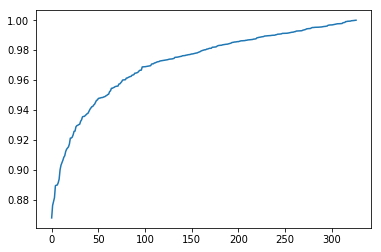

In [45]:
svm_scores = list(score_dict.values())
plt.plot(sorted(svm_scores))
plt.show()

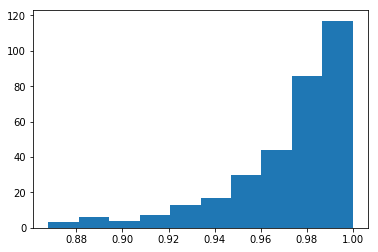

In [46]:
plt.hist(svm_scores)
plt.show()

In [42]:
save_obj(clf_dict, 'Classifier_Dict_CCNA')

In [64]:
def get_precision_recall(y_true, y_pred):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1:
            tp+=1
        elif y_true[i] == 1 and y_pred[i] == 0:
            fn+=1
        elif y_true[i] == 0 and y_pred[i] == 0:
            tn+=1
        else:
            fp+=1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print ('Precision: ', precision, 'Recall: ', recall)
    return precision, recall

In [66]:
precision_dict = {}
recall_dict = {}
good_skus = []
for sku in y_test_dict:
    total_gt_encoded = []
    total_predictions = []
    for label in y_test_dict[sku]:
        if label == sku:
            total_gt_encoded += [1]
        else:
            total_gt_encoded += [0]
    for predicted_label in predictions_dict[sku]:
        if label == sku:
            total_predictions += [1]
        else:
            total_predictions += [0]
    try:
        precision_dict[sku], recall_dict[sku] = get_precision_recall(total_gt_encoded, total_predictions)
        if ((precision_dict[sku]>=0.85) and (recall_dict[sku]>=0.85)):
            good_skus += [sku]
    except ZeroDivisionError:
        continue

('Precision: ', 0, 'Recall: ', 1)


In [67]:
print (good_skus)

[]


In [ ]:
def get_subset_training_and_testing_data(training_embedding_dict, testing_embedding_dict, k, min_test_size = 20, evaluation_mode = 1):
    X_train, y_train_actual = np.empty((0, 128)), []
    X_test, y_test_actual = np.empty((0, 128)), []
    for sku in training_embedding_dict:
        if sku in testing_embedding_dict:
            if total_sku_image_count_training[sku]>=k and total_sku_image_count_testing[sku]>=min_test_size:
                tot_embs = training_embedding_dict[sku]
                if not evaluation_mode:
                    X_train = np.vstack((X_train, tot_embs[np.random.randint(len(tot_embs), size=k)]))
                    y_train_actual += k*[sku]
                else:
                    X_train = np.vstack((X_train, tot_embs))
                    y_train_actual += len(tot_embs)*[sku]
                if sku in testing_embedding_dict:
                    X_test = np.vstack((X_test, testing_embedding_dict[sku]))
                    y_test_actual += len(testing_embedding_dict[sku])*[sku]
    return X_train, np.asarray(y_train_actual), X_test, np.asarray(y_test_actual)

In [ ]:
#Snippet of interest for producing the standard baseline results
X_train, y_train, X_test, y_test = get_subset_training_and_testing_data(training_embedding_dict, testing_embedding_dict, k = 20, min_test_size=20, evaluation_mode = 1)
start = time.time()
ovr_clf = LinearSVC()
ovr_clf.fit(X_train, y_train)
end = time.time()
print ('time to train linear SVC: ', end-start)
accuracy = ovr_clf.score(X_test,y_test)
predictions = ovr_clf.predict(X_test)
ovr_clf_report = classification_report(y_test, predictions)
classification_report_csv(ovr_clf_report, 'linear_svc_Final_full_tr_data_std_min_20.csv')
rep = pd.read_csv('linear_svc_Final_full_tr_data_std_min_20.csv')
good_skus = rep[(rep.precision >= 0.85) & (rep.recall >= 0.85)]
no_of_good_skus = len(good_skus)
print ('Total_good_skus according to standard eval test: ', no_of_good_skus)
print ('SVM accuracy: ', accuracy)

In [ ]:
def evaluate_wrt_no_of_training_images(training_embedding_dict, testing_embedding_dict, k = 100, precision_recall_tolerance = 0.85):
    X_train, y_train_actual, X_test, y_test_actual = get_subset_training_and_testing_data(training_embedding_dict, testing_embedding_dict, k, evaluation_mode = 0)
    #start = time.time()
    ovr_clf = LinearSVC()
    ovr_clf.fit(X_train, y_train_actual)
    #end = time.time()
    accuracy = ovr_clf.score(X_test,y_test_actual)
    predictions = ovr_clf.predict(X_test)
    ovr_clf_report = classification_report(y_test_actual, predictions)
    classification_report_csv(ovr_clf_report, 'new_linear_svc_cr.csv')
    rep = pd.read_csv('new_linear_svc_cr.csv')
    good_skus = rep[(rep.precision >= 0.85) & (rep.recall >= 0.85)]
    no_of_good_skus = len(good_skus)
    return no_of_good_skus, accuracy

In [ ]:
start = time.time()
results = [evaluate_wrt_no_of_training_images(training_embedding_dict, testing_embedding_dict, k=k) for k in range(20,1000,10)]
end = time.time()
print ('Total evaluation time: '+ str(end-start))

In [ ]:
X_axis = [float(k) for k in range(20,1000,10)]
results = np.asarray(results, dtype = np.float32)
plt.plot(list(X_axis), list(results[:,0]))
plt.show()

In [ ]:
plt.plot(list(X_axis), list(results[:,1]))
plt.show()

In [ ]:
le = LE() 

In [ ]:
le = le.fit(np.concatenate((y_test, y_train)))
#print (len(le.classes_))
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
start = time.time()
rfa_clf = RandomForestClassifier(min_samples_leaf=20, n_jobs=5)
rfa_clf.fit(X_train, y_train)
end = time.time()
print ("Random Forest", end - start, rfa_clf.score(X_test,y_test))
rfa_proba = rfa_clf.predict_proba(X_test)

In [ ]:
n_estimators = 10
start = time.time()
ens_clf = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), max_samples=1.0 / n_estimators, n_estimators=n_estimators),5)
ens_clf.fit(X_train, y_train)
end = time.time()
print ("Bagging SVC", end - start, ens_clf.score(X_test,y_test))
ens_proba = ens_clf.predict_proba(X_test)

In [ ]:
start = time.time()
ovr_clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), 5)
ovr_clf.fit(X_train, y_train)
end = time.time()
print ("Single SVC", end - start, ovr_clf.score(X_test,y_test))
ovr_proba = ovr_clf.predict_proba(X_test)

In [ ]:
clf = LinearSVC(C=50,class_weight='balanced',max_iter=100000)
clf.fit(X_train, y_train)

#y_score = clf.decision_function(X_test)
predictions = clf.predict(X_test)
report = classification_report(y_test, predictions)



In [ ]:
n_training_classes = len(training_sku_id_set)
n_testing_classes = len(testing_sku_id_set)
print ('Training_classes: ', n_training_classes)
print ('Testing_classes: ', n_testing_classes)
n_classes = n_training_classes

In [ ]:
def plot_roc(y_score, y_test, cls_index = -1, avg = True, lw = 2):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    if cls_index!=-1:
        plt.figure()
        plt.plot(fpr[2], tpr[2], color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()
    if avg:
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        #for i, color in zip(range(n_classes), colors):
        #    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
        #             label='ROC curve of class {0} (area = {1:0.2f})'
        #             ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()

In [ ]:
plot_roc(y_score, y_test, -1, True)

In [41]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)